In [1]:
import tensorflow as tf
from tensorflow import keras
import theano.tensor as T
import pymc3 as pm
import numpy as np
import seaborn as sns

In [2]:
tfmodel = keras.models.load_model('../test_grid_model.h5')

In [3]:
tfmodel.summary()

Model: "test_grid_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
outputs (Dense)              (None, 3)                 33        
Total params: 173
Trainable params: 173
Non-trainable params: 0
_________________________________________________________________


In [4]:
weights_list = tfmodel.get_weights()

In [5]:
def nn(input):
    nh_layers = int(len(weights_list) / 2 - 2)
    xx = T.nnet.elu(pm.math.dot(input, weights_list[0]) + weights_list[1])
    for hl in range(1, 1+nh_layers):
        xx = T.nnet.elu(pm.math.dot(xx, weights_list[hl * 2]) + weights_list[hl * 2 + 1])
    xx = pm.math.dot(xx, weights_list[-2]) + weights_list[-1]
    return 10**(xx)

In [6]:
params = ['star_age', 'initial_mass']
obs = ['radius', 'effective_T', 'delta_nu']

In [7]:
nn([np.log10(4.5), np.log10(1.0)]).eval()

array([1.14267237e+00, 6.08204420e+03, 1.13291452e+02])

In [19]:
inputs = np.array([[np.log10(4.5), np.log10(2.5)] , [np.log10(1.0),np.log10(1.0)]]).T
outputs = nn(inputs).eval()

In [20]:
obs_unc = np.array([[0.01, 70.0, 1.0],[0.01, 70.0, 1.0]])
obs_ = outputs + np.random.randn(*outputs.shape) * obs_unc
print(obs_)

[[1.14717312e+00 6.15404091e+03 1.13884440e+02]
 [1.07556724e+00 6.59836168e+03 1.18863623e+02]]


In [22]:
model = pm.Model()

with model:
    mass = pm.Normal('mass', 1.0, 0.2, shape=2)
    age = pm.Normal('age', 4.5, 1.0, shape=2)
    
    star1 = [np.log10(age[0]), np.log10(mass[0])]
    star2 = [np.log10(age[1]), np.log10(mass[1])]
    obs_prop = pm.Deterministic('obs_prop', nn(T.stacklists([star1, star2])))
    
    like = pm.Normal('like', obs_prop, obs_unc, observed=obs_)

In [23]:
inits = ['adapt_diag']
start = {'mass': [1.0, 1.01], 'age': [4.5, 4.5]}

with model:
    trace = pm.sample(tune=1000, init=inits[0], start=start, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, mass]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


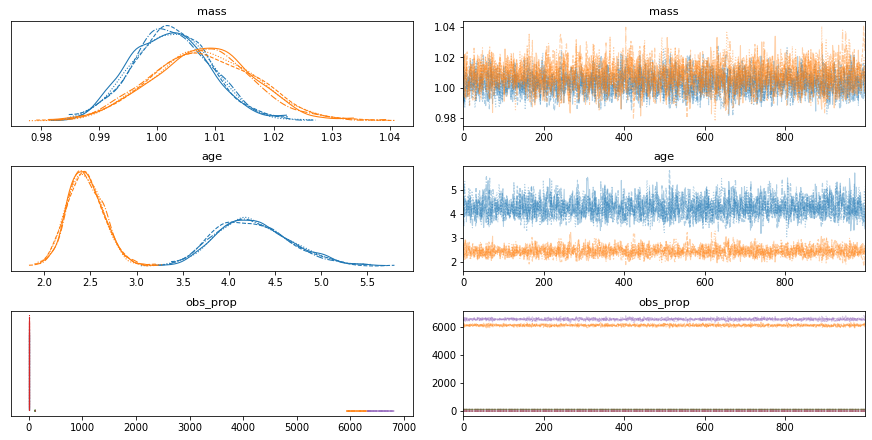

In [24]:
pm.traceplot(trace);

In [25]:
pm.summary(trace)

/Users/davies/Library/Python/3.7/lib/python/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mass[0],1.003,0.007,0.990,1.015,0.000,0.000,1868.0,1868.0,1864.0,2155.0,1.0
mass[1],1.008,0.009,0.992,1.024,0.000,0.000,1983.0,1983.0,1989.0,2203.0,1.0
age[0],4.266,0.394,3.598,5.049,0.009,0.006,2032.0,2018.0,2047.0,2074.0,1.0
age[1],2.452,0.194,2.092,2.809,0.004,0.003,1994.0,1974.0,2018.0,2190.0,1.0
"obs_prop[0,0]",1.141,0.007,1.127,1.154,0.000,0.000,3820.0,3819.0,3826.0,3047.0,1.0
"obs_prop[0,1]",6123.530,64.043,6005.392,6241.330,1.409,0.996,2066.0,2066.0,2071.0,2153.0,1.0
"obs_prop[0,2]",113.343,0.732,112.024,114.746,0.013,0.009,3023.0,3023.0,3024.0,2954.0,1.0
"obs_prop[1,0]",1.083,0.006,1.072,1.094,0.000,0.000,4539.0,4538.0,4541.0,3211.0,1.0
"obs_prop[1,1]",6555.066,69.975,6429.678,6687.566,1.585,1.121,1950.0,1950.0,1962.0,1979.0,1.0
"obs_prop[1,2]",119.361,0.776,117.944,120.783,0.011,0.008,5311.0,5311.0,5302.0,3470.0,1.0
